[![Colab Badge Link](https://img.shields.io/badge/open-in%20colab-blue)](https://colab.research.google.com/github/Glasgow-AI4BioMed/tutorials/blob/main/vector_similarity_with_a_neural_network.ipynb)

# Vector similarity with a neural network

This Colab notebook illustrates how you could train a neural network that takes in two vector representations to evaluate similarity.

## Architecture

The neural network that we'll construct together follows the design in the image below.

- Two vectors are input (potentially from some encoder like a frozen transformer)
- The vectors are linearly transformed (using the trained parameters of the neural network)
- The two vectors are dot-producted and a sigmoid is applied to give an output score

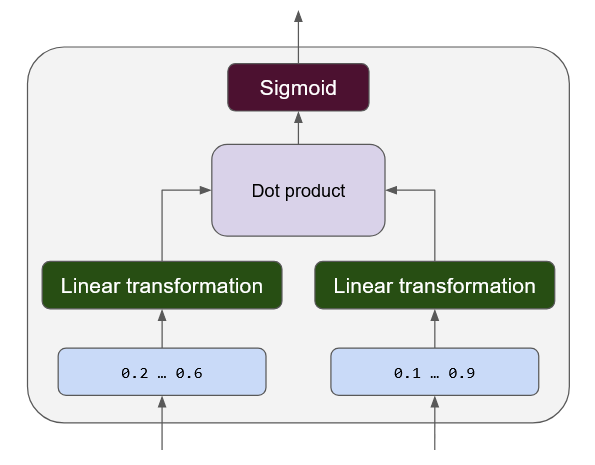

The training process will involve taking pairs of vectors, feeding them through the neural network and updating the neural network so that resulting output is closer to the true label.

## Creating an artificial dataset

We will use an artificial dataset where we assume that the input vectors for a set of queries/documents have been precomputed by feeding them through an encoder (e.g. a frozen transformer). We'll actually create some random data to simulate this.

All of this will be done using pytorch:

In [ ]:
import torch

And we're going to generate some random data so let's set some seeds for consistency:

In [ ]:
torch.manual_seed(42)

import random
random.seed(42)

We'll pick some arbitrary settings and decide that the vectors should be of dimension `50` and that we will have `10000` pairs of vectors.

In [ ]:
dim = 50
N = 10000

Let's create those vectors:

In [ ]:
vectors_1 = torch.rand(N, dim)
vectors_2 = torch.rand(N, dim)

Now we want to create some challenge labels for these pairs of vectors. Let's imagine that only part of the vector is actually useful and create labels based on the cosine similarity of the first five elements of each vector. This is purely to create a simulated challenge.

In [ ]:
labels = []
for i in range(N):
  # Calculate the cosine similarity of the first five elements of each vector
  v1 = vectors_1[i,:5]
  v2 = vectors_2[i,:5]
  cosine_sim = v1.dot(v2) / (torch.norm(v1) * torch.norm(v2))

  # Declare the vectors as similar if they have cosine similarity greater than 0.8
  artificial_label = cosine_sim > 0.8

  labels.append(artificial_label)

Convert the labels to a pytorch tensor with type float:

In [ ]:
labels = torch.tensor(labels).float()

Check what they look like:

In [ ]:
labels

And see how many of the `10000` are positive by summing the labels:

In [ ]:
sum(labels)

### Split the dataset into training & validation parts

We'll want to train and evaluate a model. For this Colab, we'll split our artificial dataset into training, validation and test parts. We'll actually only use the training & validation sets in this code.

We'll use a 60/20/20 split. The code is one possible way of doing the splitting

In [ ]:
N_train = int(0.6 * N)
N_val = int(0.2 * N)
N_test = N - N_train - N_val

Let's get the indices of the training, validation and test sets.

In [ ]:
all_indices = list(range(N))
random.shuffle(all_indices)

train_indices = all_indices[:N_train]
val_indices = all_indices[N_train:(N_train+N_val)]
test_indices = all_indices[(N_train+N_val):]

len(train_indices), len(val_indices), len(test_indices)

And now let's split our vectors and label tensors into their separate parts for training, validation and testing:

In [ ]:
train_vectors_1 = vectors_1[train_indices,:]
train_vectors_2 = vectors_2[train_indices,:]
train_labels = labels[train_indices]

val_vectors_1 = vectors_1[val_indices,:]
val_vectors_2 = vectors_2[val_indices,:]
val_labels = labels[val_indices]

test_vectors_1 = vectors_1[test_indices,:]
test_vectors_2 = vectors_2[test_indices,:]
test_labels = labels[test_indices]

## Try out cosine similarity

Now let's try calculating cosine similarity directly using the existing vectors. Really there isn't any "training" involved here as there is no model to train. We'll be calculating the cosine similarity and would need to choose a `threshold` above which two documents are declared similar. We'll pick `0.7` and this could be tweaked using the training set:

In [ ]:
threshold = 0.7

Now let's try out cosine similarity on the training set:

In [ ]:
predicted_labels = []
for i in range(N_train):
  v1 = train_vectors_1[i,:]
  v2 = train_vectors_2[i,:]

  cosine_sim = v1.dot(v2) / (torch.norm(v1) * torch.norm(v2))

  predicted_label = cosine_sim > threshold
  predicted_labels.append(predicted_label)

We'll use the metrics functions from scikit-learn:

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

And calculate the predicted labels using thresholded cosine similarity against the known labels for the training set:

In [ ]:
print(f"{accuracy_score(train_labels, predicted_labels)=:.3f}")
print(f"{recall_score(train_labels, predicted_labels)=:.3f}")
print(f"{precision_score(train_labels, predicted_labels)=:.3f}")
print(f"{f1_score(train_labels, predicted_labels)=:.3f}")

Not a very high accuracy and the recall looks like it mostly just predicts everything to be similar.

Let's calculate on the validation set:

In [ ]:
predicted_labels = []
for i in range(N_val):
  v1 = val_vectors_1[i,:]
  v2 = val_vectors_2[i,:]

  cosine_sim = v1.dot(v2) / (torch.norm(v1) * torch.norm(v2))

  predicted_label = cosine_sim > threshold
  predicted_labels.append(predicted_label)

In [ ]:
print(f"{accuracy_score(val_labels, predicted_labels)=:.3f}")
print(f"{recall_score(val_labels, predicted_labels)=:.3f}")
print(f"{precision_score(val_labels, predicted_labels)=:.3f}")
print(f"{f1_score(val_labels, predicted_labels)=:.3f}")

Very similar scores on the validation set

## Training a bi-encoder model

Let's implement a bi-encoder model that can transform the vectors before applying a dot-product. We'll work through the components of it.

First, we'll want a batch of input vectors. Let's say the batch is of size `32`. We've got 32 vectors for the first document (`vectors_1`) and 32 vectors for the corresponding second documents (`vectors_2`). By the end, we'll want 32 output scores. Let's create some dummy input data to work with:

In [ ]:
vectors_1 = torch.rand(32, dim)
vectors_2 = torch.rand(32, dim)

Then we need some linear layers for transformations:

In [ ]:
import torch.nn as nn

linear_1 = nn.Linear(dim,dim)
linear_2 = nn.Linear(dim,dim)

And we then do the transformation:

In [ ]:
vectors_1 = linear_1(vectors_1)
vectors_2 = linear_2(vectors_2)

And lastly, we'll want to calculate the dot-products. We could do it one at a time with the `.dot` function like below:

In [ ]:
vectors_1[0,:].dot(vectors_2[0,:])

Or we can do it with element-wise multiplication and then summing each row:

In [ ]:
rowwise_dot = (vectors_1 * vectors_2).sum(axis=1)
rowwise_dot.shape

A quick check that the first dot-product value gives what we got above with the `.dot` function:

In [ ]:
rowwise_dot[0]

Lastly, we run the dot-product scores through a sigmoid function to turn them into scores that work well for classification (between 0 and 1). Practically we could then use a threshold of 0.5 to decide if something is classified as similar or not similar.

In [ ]:
torch.sigmoid(rowwise_dot)

### Putting it into a model

We can put all this logic inside a Pytorch model as below.

In [ ]:
class CustomBiEncoder(nn.Module):
  def __init__(self, dim):
    super().__init__()

    self.linear_1 = nn.Linear(dim, dim)
    self.linear_2 = nn.Linear(dim, dim)

  def forward(self, vectors_1, vectors_2):
    vectors_1 = self.linear_1(vectors_1)
    vectors_2 = self.linear_2(vectors_2)

    rowwise_dot = (vectors_1 * vectors_2).sum(axis=1)

    scores = torch.sigmoid(rowwise_dot)

    return scores

And we can instantiante our model with:

In [ ]:
model = CustomBiEncoder(dim)

Let's run some test data through it. We'll create some random vectors and labels to test it out and figure out how to calculate the loss

In [ ]:
vectors_1 = torch.rand(32, dim)
vectors_2 = torch.rand(32, dim)
labels = torch.randint(low=0, high=2, size=(32,)).float()

Now let's get the output of the model with the pairs of vectors as input

In [ ]:
outputs = model(vectors_1,vectors_2)
outputs.shape

What do the output scores look like?

In [ ]:
outputs[:5]

We can calculate the loss between these output values against our (randomly generated) test labels using a binary cross entropy loss function:

In [ ]:
loss_func = nn.BCELoss()

We then pass the output scores and the known labels

In [ ]:
loss_func(outputs, labels)

The training process will try to minimise this loss and hopefully create a vector similarity measure that effectively identifies similar or not similar vectors.

### Training the model

Let's train our model. This will update the two linear transformations to improve the vector similarity calculations.

First, we need to decide some hyperparameters when tuning. Practically, hyperparameter tuning should be done to find the best values for these. We'll pick a few arbitrarily.

In [ ]:
num_epochs = 10
learning_rate = 0.001
batch_size = 8

We also package the various tensors together with `TensorDataset` and `DataLoader` to make it easier to load the data and iterate through it

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_vectors_1, train_vectors_2, train_labels)
val_dataset = TensorDataset(val_vectors_1, val_vectors_2, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

We could train on a GPU, but for this Colab we'll set the device to `cpu` to do CPU training. It should be set to `cuda` if a GPU is available.

In [ ]:
device = 'cpu'

We'll create the optimiser that will do the hard work of updating the model parameters (which are the two linear layers)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

And now we run the training loop. This is a fairly standard PyTorch training loop that iterates over the training set and updates the model. It then iterates over the validation set and calculates some metrics.

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for vectors_1, vectors_2, labels in train_loader:
        vectors_1, vectors_2, labels = vectors_1.to(device), vectors_2.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(vectors_1, vectors_2)
        loss = loss_func(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation after each epoch
    model.eval()
    val_loss = 0.0
    val_predictions = []

    with torch.no_grad():
        for vectors_1, vectors_2, labels in val_loader:
            vectors_1, vectors_2, labels = vectors_1.to(device), vectors_2.to(device), labels.to(device)

            # Forward pass and compute loss
            outputs = model(vectors_1, vectors_2)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()

            # Threshold the output scores and add to the predictions list
            predicted = outputs > 0.5
            val_predictions += predicted.tolist()

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_f1 = f1_score(val_labels, val_predictions)

    print(f"{epoch=} {train_loss=:.4f} {val_loss=:.4f} {val_accuracy=:.4f} {val_f1=:.4f}")


The training should have produced much higher accuracy than the original cosine similarity method. This shows that the model has adapted the input vectors into vectors that are better for comparisons using dot-product

## Further directions

- Hyperparameter tuning: This is generally essential to get the best performance out of a model and would likely improve the performance on the validation set
- Evaluation on the test set: Any final experiments should be evaluated with the test set to get final performance numbers
- Tweaking the model: Different architectures could be tried including changing the vector dimensions, adding dropout, additional layers with extra non-linear activations, etc
- Applying for ranking: After the model has been trained well in a classification setting, it could be deployed for a ranking problem where it can quickly be applied to all pairs of precalculated document vectors